# RL homework 3

-------------------------------



**Start date:** *7th March 2018*

**Due date:** *21st March 2018, 11:55 pm*

------------------------------------


## Context

In this assignment, we will investigate the properties of 3 distinct reinforcement learning algorithms:

* Online Q-learning
* Experience Replay
* Dyna-Q

We will consider two different dimensions:
* Tabular vs Function Approximation
* Stationary vs Non-Stationary environments

## Background reading

* Sutton and Barto (2018), Chapters 8

# The Assignment

### Objectives

You will use Python to implement several reinforcement learning algorithms **[50 pts]**.

You will then run these algorithms on a few problems, to understand their properties.

Finally you will answer a few question about the performance of these algorithms in the various problems **[50pts]**.

# Setup

In [0]:
import matplotlib.pyplot as plt
import numpy as np
from collections import namedtuple

np.set_printoptions(precision=3, suppress=1)
plt.style.use('seaborn-notebook')

# Grid worlds

**Tabular Grid-World**

Simple tabular grid world.

You can visualize the grid worlds we will train our agents on, by running the cells below.
`S` indicates the start state and `G` indicates the goal.  The agent has four possible actions: up, right, down, and left.  Rewards are: `-5` for bumping into a wall, `+10` for reaching the goal, and `0` otherwise.  The episode ends when the agent reaches the goal, and otherwise continues.  The discount, on continuing steps, is $\gamma = 0.9$.

We will use three distinct GridWorlds:
* `Grid` tabular grid world withh a goal in the top right of the grid
* `AltGrid` tabular grid world withh a goal in the bottom left of the grid
* `FeatureGrid` a grid world with a non tabular representation of states, the features are such to allow some degree of state aliasing

In [0]:
#@title Grid
class Grid(object):

  def __init__(self, discount=0.9):
    # -1: wall
    # 0: empty, episode continues
    # other: number indicates reward, episode will terminate
    self._layout = np.array([
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0, 10, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
      [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
    ])
    self._start_state = (2, 2)
    self._goal_state = (8, 2)
    self._state = self._start_state
    self._number_of_states = np.prod(np.shape(self._layout))
    self._discount = discount

  @property
  def number_of_states(self):
      return self._number_of_states
    
  def plot_grid(self):
    plt.figure(figsize=(3, 3))
    plt.imshow(self._layout > -1, interpolation="nearest", cmap="pink")     
    ax = plt.gca()
    ax.grid(0)
    plt.xticks([])
    plt.yticks([])
    plt.title("The grid")
    plt.text(
        self._start_state[0], self._start_state[1], 
        r"$\mathbf{S}$", ha='center', va='center')
    plt.text(
        self._goal_state[0], self._goal_state[1], 
        r"$\mathbf{G}$", ha='center', va='center')
    h, w = self._layout.shape
    for y in range(h-1):
      plt.plot([-0.5, w-0.5], [y+0.5, y+0.5], '-k', lw=2)
    for x in range(w-1):
      plt.plot([x+0.5, x+0.5], [-0.5, h-0.5], '-k', lw=2)

  
  def get_obs(self):
    y, x = self._state
    return y*self._layout.shape[1] + x
  
  def int_to_state(self, int_obs):
    x = int_obs % self._layout.shape[1]
    y = int_obs // self._layout.shape[1]
    return y, x

  def step(self, action):
    y, x = self._state

    if action == 0:  # up
      new_state = (y - 1, x)
    elif action == 1:  # right
      new_state = (y, x + 1)
    elif action == 2:  # down
      new_state = (y + 1, x)
    elif action == 3:  # left
      new_state = (y, x - 1)
    else:
      raise ValueError("Invalid action: {} is not 0, 1, 2, or 3.".format(action))

    new_y, new_x = new_state
    if self._layout[new_y, new_x] == -1:  # wall
      reward = -5.
      discount = self._discount
      new_state = (y, x)
    elif self._layout[new_y, new_x] == 0:  # empty cell
      reward = 0.
      discount = self._discount
    else:  # a goal
      reward = self._layout[new_y, new_x]
      discount = 0.
      new_state = self._start_state
    
    self._state = new_state
    return reward, discount, self.get_obs()

In [0]:
#@title AltGrid
class AltGrid(Grid):
  
    def __init__(self, discount=0.9):
      # -1: wall
      # 0: empty, episode continues
      # other: number indicates reward, episode will terminate
      self._layout = np.array([
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0, -1, -1,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0,  0,  0,  0,  0,  0,  0,  0, -1],
        [-1,  0, 10,  0,  0,  0,  0,  0,  0, -1],
        [-1, -1, -1, -1, -1, -1, -1, -1, -1, -1]
      ])
      self._start_state = (2, 2)
      self._goal_state = (2, 7)
      self._state = self._start_state
      self._number_of_states = np.prod(np.shape(self._layout))
      self._discount = discount

In [0]:
#@title FeatureGrid
class FeatureGrid(Grid):
  
  def get_obs(self):
    return self.state_to_features(self._state)
  
  def state_to_features(self, state):
    y, x = state
    x /= float(self._layout.shape[1] - 1)
    y /= float(self._layout.shape[0] - 1)
    markers = np.arange(0.1, 1.0, 0.1)
    features = np.array([np.exp(-40*((x - m)**2+(y - n)**2))
                         for m in markers
                         for n in markers] + [1.])
    return features / np.sum(features**2)
  
  def int_to_features(self, int_state):
    return self.state_to_features(self.int_to_state(int_state))
  
  @property
  def number_of_features(self):
      return len(self.get_obs())

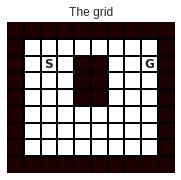

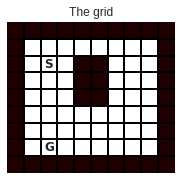

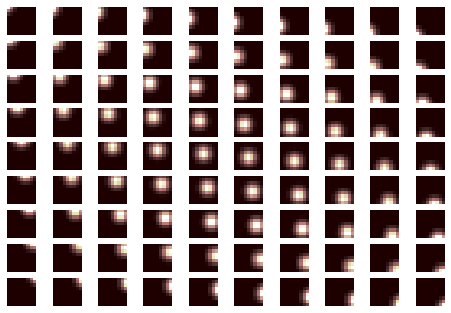

In [5]:
# Instantiate the two tabular environments
grid = Grid()
alt_grid = AltGrid()

# Plot tabular environments
grid.plot_grid()
alt_grid.plot_grid()

# Instantiate the non tabular version of the environment.
feat_grid = FeatureGrid()

# Plot the features of each state
shape = feat_grid._layout.shape
f, axes = plt.subplots(shape[0], shape[1])
for state_idx, ax in enumerate(axes.flatten()):
  ax.imshow(np.reshape((feat_grid.int_to_features(state_idx)[:-1]),(9,9)), interpolation='nearest', cmap="pink")
  ax.set_xticks([])
  ax.set_yticks([])

# Helper functions

In [0]:
def run_experiment(env, agent, number_of_steps):
    mean_reward = 0.
    try:
      action = agent.initial_action()
    except AttributeError:
      action = 0
    for i in range(number_of_steps):
      reward, discount, next_state = env.step(action)
      action = agent.step(reward, discount, next_state)
      mean_reward += (reward - mean_reward)/(i + 1.)

    return mean_reward

map_from_action_to_subplot = lambda a: (2, 6, 8, 4)[a]
map_from_action_to_name = lambda a: ("up", "right", "down", "left")[a]

def plot_values(values, colormap='pink', vmin=-1, vmax=10):
  plt.imshow(values, interpolation="nearest", cmap=colormap, vmin=vmin, vmax=vmax)
  plt.yticks([])
  plt.xticks([])
  plt.colorbar(ticks=[vmin, vmax])

def plot_state_value(action_values):
  q = action_values
  fig = plt.figure(figsize=(4, 4))
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")

def plot_action_values(action_values):
  q = action_values
  fig = plt.figure(figsize=(8, 8))
  fig.subplots_adjust(wspace=0.3, hspace=0.3)
  vmin = np.min(action_values)
  vmax = np.max(action_values)
  dif = vmax - vmin
  for a in [0, 1, 2, 3]:
    plt.subplot(3, 3, map_from_action_to_subplot(a))
    
    plot_values(q[..., a], vmin=vmin - 0.05*dif, vmax=vmax + 0.05*dif)
    action_name = map_from_action_to_name(a)
    plt.title(r"$q(s, \mathrm{" + action_name + r"})$")
    
  plt.subplot(3, 3, 5)
  v = 0.9 * np.max(q, axis=-1) + 0.1 * np.mean(q, axis=-1)
  plot_values(v, colormap='summer', vmin=vmin, vmax=vmax)
  plt.title("$v(s)$")
  
def random_policy(q):
  return np.random.randint(4)

def plot_greedy_policy(grid, q):
  action_names = [r"$\uparrow$",r"$\rightarrow$", r"$\downarrow$", r"$\leftarrow$"]
  greedy_actions = np.argmax(q, axis=2)
  grid.plot_grid()
  plt.hold('on')
  for i in range(9):
    for j in range(10):
      action_name = action_names[greedy_actions[i,j]]
      plt.text(j, i, action_name, ha='center', va='center')

# Part 1: Implement Agents

Each agent, should implement a step function:

### `__init__(self, number_of_actions, number_of_states, initial_observation)`:
The constructor will provide the agent the number of actions, number of states, and the initial observation. You can get the initial observation by first instatiating an environment, using `grid = Grid()`, and then calling `grid.get_obs()`.

All agents should be in pure Python - so you cannot use TensorFlow to, e.g., compute gradients.  Using `numpy` is fine.

### `step(self, reward, discount, next_observation, ...)`:
where `...` indicates there could be other inputs (discussed below).  The step should update the internal values, and return a new action to take.

When the discount is zero ($\text{discount} = \gamma = 0$), then the `next_observation` will be the initial observation of the next episode.  One shouldn't bootstrap on the value of this state, which can simply be guaranteed when using "$\gamma \cdot v(\text{next_observation})$" (for whatever definition of $v$ is appropriate) in the update, because $\gamma = 0$.  So, the end of an episode can be seamlessly handled with the same step function.

### `q_values()`:

Tabular agents implement a function `q_values()` returning a matrix of Q values of shape: (`number_of_states`, `number_of_actions`)

### `q_values(state)`:

Agents with Linear function approximation implement a method `q_values(state)` returning an array of Q values of shape: (`number_of_actions`)


### A note on the initial action
Normally, you would also have to implement a method that gives the initial action, based on the initial state.  As in the previous assignment you can use the action `0` (which corresponds to `up`) as initial action, so that otherwise we do not have to worry about this.  Note that this initial action is only executed once, and the beginning of the first episode---not at the beginning of each episode.

Q-learning and it's variants needs to remember the last action in order to update its value when they see the next state.  In the `__init__`, make sure you set the initial action to zero, e.g.,
```
def __init__(...):
  (...)
  self._action = 0
  (...)
```



# Part 1: Implement Agents

We are going to implement 5 agent:
- Online Tabular Q-learning
- Tabular Experience Replay
- Tabular Dyna-Q (with a Tabular model)
- Experience Replay with linear function approximation
- Dyna-Q with linear function approximation (with a linear model)



## 1.1 Tabular Model
**[5 pts]** Implement a trainable tabular Model of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the next state in the environment.
* a *reward* method, taking a state and action and returning the immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

Given that the environment is deterministic and tabular the model will basically reduce to a simple lookup table.

In [0]:
class TabularModel(object):

  def __init__(self, number_of_states, number_of_actions):
    self._action = 0
    self._number_of_states = number_of_actions
    self._number_of_actions = number_of_actions
    self._m = dict()

  def next_state(self, s, a):
#     try:
    return self._m[(s,a)][2]
#     except KeyError:
#       pass
  
  def reward(self, s, a):
#     try:
    return self._m[(s,a)][0]
#     except KeyError:
#       pass

  def discount(self, s, a):
#     try:
    return self._m[(s,a)][1]
#     except KeyError:
#       pass
  
  def transition(self, state, action):
    return (
        self.reward(state, action), 
        self.discount(state, action),
        self.next_state(state, action))
  
  def update(self, state, action, reward, discount, next_state):
      self._m[(state,action)] = [reward, discount, next_state]

## 1.2 Linear Model

**[5 pts]** Implement a trainable linear model of the environment.

The Model should implement: 
* a *next_state* method, taking a state and action and returning the predicted next state in the environment.
* a *reward* method, taking a state and action and returning the predicted immediate reward associated to execution that action in that state.
* a *discount* method, taking a state and action and returning the predicted discount associated to execution that action in that state.
* a *transition* method, taking a state and an action and returning both the next state and the reward associated to that transition.
* a *update* method, taking a full transition *(state, action, reward, next_state)* and updating the model (in its reward, discount and next_state component)

For each selected action, the predicted reward, discount and next state will all be a linear function of the state.
* $\text{s'} = T_a s$
* $\text{r'} = R_a s$
* $\text{g'} = G_a s$

Where $T_a$ is a matrix of shape $(\text{number_of_features}, \text{number_of_features})$, $R_a$ and $G_a$are vectors of shape $(\text{number_of_features},)$

The parameters of all these linear transformations must be trained by gradient descent. Write down the update to the parameters of the models and implement the update in the model below.



In [0]:
class LinearModel(object):

  def __init__(self, number_of_features, number_of_actions):
    self._number_of_features = number_of_features
    self._number_of_actions = number_of_actions
    self._T = np.zeros((number_of_actions, number_of_features, number_of_features))
    self._R = np.zeros((number_of_actions, number_of_features))
    self._G = np.zeros((number_of_actions, number_of_features))

  def next_state(self, s, a):
    #feature vector
    return np.dot(self._T[a, :, :], s)
  
  def reward(self, s, a):
    return np.dot(self._R[a, :], s)

  def discount(self, s, a):
    return np.dot(self._G[a, :], s)

  def transition(self, state, action):
    return (
        self.reward(state, action),
        self.discount(state, action),
        self.next_state(state, action))

  def update(self, state, action, reward, discount, next_state, step_size=0.1):
    
    _r, _g, _s = self.transition(state, action)
    
    self._R[action, :] += step_size *(reward - _r) * state
    self._G[action, :] += step_size *(discount - _g) * state
    self._T[action,:,:] += step_size * np.dot((next_state - _s).reshape(-1,1), state.reshape(1,-1))


## 1.3 Experience Replay

**[10 pts]** Implement an agent that uses **Experience Replay** to learn action values, at each step:
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning 
* apply multiple Q-learning updates based on transitions sampled (uniformly) from the *replay buffer* (in addition to the online updates).

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A, R, \gamma, S' \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
 class ExperienceQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self._q = np.zeros((number_of_states, number_of_actions))
    self._buffer = []
    self._number_of_actions = number_of_actions #4
    self._state = initial_state
    self._action = 0
    self._behaviour_policy = behaviour_policy #random
    self._num_offline_updates = num_offline_updates
    self._alpha = step_size
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self._action = self._behaviour_policy(self._q)
    
    self._q[s,a] += self._alpha*(r + g*np.max(self._q[next_s,:])-self._q[s,a])
    self._buffer.append((s, a, r, g, next_s))
    
    for i in range(self._num_offline_updates):
      l = np.random.randint(len(self._buffer))
      s_, a_, r_, g_, next_s_ = self._buffer[l]
      self._q[s_,a_] += self._alpha*(r_ + g_*np.max(self._q[next_s_,:])-self._q[s_,a_])
    
    self._state = next_state
    
    return self._action


## 1.4 Dyna-Q
**[10 pts]** Implement an agent that uses **Dyna-Q** to learn action values.  
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A)$

6. $\text{Model}.\text{update}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  2. $R, \gamma, S' \gets \text{Model}.\text{transition}(S, A)$
  
  3. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
class DynaQ(object):

  def __init__(
      self, number_of_states, number_of_actions, initial_state, 
      behaviour_policy, num_offline_updates=0, step_size=0.1):
    
    self._q = np.zeros((number_of_states, number_of_actions))
    self._m = TabularModel(number_of_states,number_of_actions)
    self._buffer = []
    self._number_of_actions = number_of_actions
    self._state = initial_state
    self._action = 0
    self._behaviour_policy = behaviour_policy
    self._num_offline_updates = num_offline_updates
    self._alpha = step_size
    
  @property
  def q_values(self):
    return self._q

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self._action = self._behaviour_policy(self._q)
    self._q[s,a] += self._alpha*(r + g*np.max(self._q[next_s,:])-self._q[s,a])
    
    self._buffer.append((s,a))
    self._m.update(s, a, r, g, next_s)
#     if (s,a) not in self._m.keys():
#       self._m[(s,a)] = dict()
#     self._m[(s,a)] = [r, g, next_s]   
    
    for i in range(self._num_offline_updates):
      #sample_from_transition
      l = np.random.randint(len(self._buffer))
      s_, a_ = self._buffer[l]
      r_, g_, next_s_ = self._m.transition(s_, a_)
      self._q[s_,a_] += self._alpha*(r_ + g_*np.max(self._q[next_s_,:])-self._q[s_,a_])
    
    self._state = next_state
    return self._action


## 1.5 Experience Replay with Linear Function Approximation

**[10 pts]** Implement an agent that uses **Experience Replay** to learn action values as a linear function approximation over a given set of features.

**Training**: To make sure of the experience in an online fashion, we will learn this linear model via gradient descent. Write down the update to the parameters of the value function and implement the update in the agent below.

In [0]:
class FeatureExperienceQ(ExperienceQ):

  def __init__(
      self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureExperienceQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self._number_of_features = number_of_features
    self._number_of_actions = number_of_actions
    self._w = np.random.randn(number_of_actions, number_of_features)

  def q(self, state):
    return np.dot(self._w, state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self._action = self._behaviour_policy(self.q(s))
    
#     q_a = np.dot(self._w[a, :], s)
#     q_next_s = np.max(np.dot(self._w, next_s))
    delta = r + g * np.max(np.dot(self._w, next_s)) - np.dot(self._w[a, :], s)
    self._w[a, :] += self._alpha * delta * s
    
    self._buffer.append((s, a, r, g, next_s))
    
    for i in range(self._num_offline_updates):
      l = np.random.randint(len(self._buffer))
      s_, a_, r_, g_, next_s_ = self._buffer[l]
      
      _delta = r_ + g_ * np.max(self.q(next_s_)) - np.dot(self._w[a_, :], s_)
      self._w[a_, :] += self._alpha * _delta * s_
    
    self._state = next_state
    return self._action  


## 1.6 Dyna-Q with Linear Function Approximation

**[10 pts]** Implement an agent that uses **Dyna-Q** that uses a linear function approximation to represent the value functions and a learnt linear model of the environment (represent and learn both the **transition model**(action conditioned) and the **reward model** as linear transformations of the given set of features).  
* select actions randomly
* accumulate all observed transitions *(s, a, r, s')* in the environment in a *replay buffer*,
* apply an online Q-learning to Q-value
* apply an update to the *model* based on the latest transition, use a step_size of 0.01
* apply multiple Q-learning updates based on transitions *(s, a, model.reward(s), model.next_state(s))* for some previous state and action pair *(s, a)*.

**Initialize** $Q(s, a)$ and $\text{Model}(s, a)$ for all s ∈ S and a ∈ A(s)

**Loop forever**:

1. $S \gets{}$current (nonterminal) state
 
2. $A \gets{} \text{random_action}(S)$
 
3. Take action $A$; observe resultant reward $R$, discount $\gamma$, and state, $S'$

4. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

5. $\text{ReplayBuffer}.\text{append_transition}(S, A)$

6. $\text{Model}.\text{update}(S, A, R, \gamma, S')$

6. Loop repeat n times:

  1. $S, A \gets \text{ReplayBuffer}.\text{sample_transition}()$
  
  2. $R, \gamma, S' \gets \text{Model}.\text{transition}(S, A)$
  
  3. $Q(S, A) \gets Q(S, A) + \alpha (R + \gamma \max_a Q(S', a) − Q(S, A))$

In [0]:
class FeatureDynaQ(DynaQ):

  def __init__(self, number_of_features, number_of_actions, *args, **kwargs):
    super(FeatureDynaQ, self).__init__(
        number_of_actions=number_of_actions, *args, **kwargs)
    self._number_of_features = number_of_features
    self._number_of_actions = number_of_actions
    self._w = np.random.randn(number_of_actions, number_of_features)
    self._model = LinearModel(number_of_features, number_of_actions)

  def q(self, state):
    return np.dot(self._w,state)

  def step(self, reward, discount, next_state):
    s = self._state
    a = self._action
    r = reward
    g = discount
    next_s = next_state
    
    self._action = self._behaviour_policy(self.q(s))
    
    delta = r + g * np.max(self.q(next_s)) - np.dot(self._w[a, :], s)
    self._w[a, :] += self._alpha * delta * s
    
    self._buffer.append((s, a))
    self._model.update(s, a, r, g, next_s, self._alpha)
    
    for i in range(self._num_offline_updates):
      l = np.random.randint(len(self._buffer))
      s_, a_,= self._buffer[l]
      r_, g_, next_s_ = self._model.transition(s_, a_)
      
      _delta = r_ + g_ * np.max(self.q(next_s_)) - np.dot(self._w[a_, :], s_)
      self._w[a_, :] += self._alpha * _delta * s_
    
    self._state = next_state
    return self._action

# Assignment 2: Analyse Results

## 2.1 Tabular Learning

### 2.1.1 Data Efficiency

**Online Q-learning**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

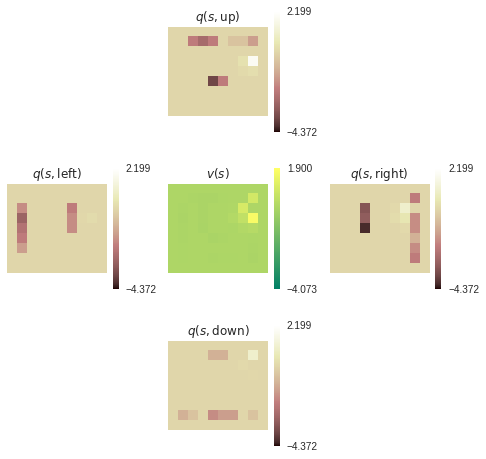

In [48]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

**Experience Replay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $0$

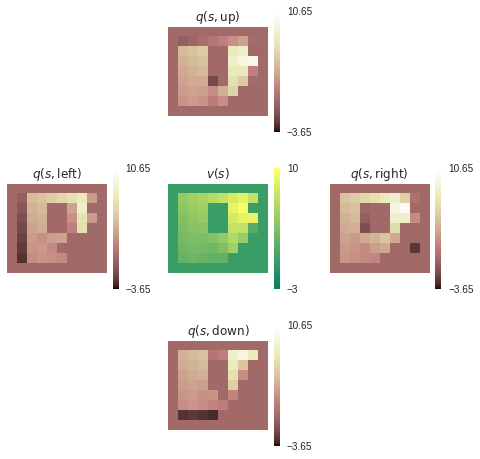

In [28]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

**DynaQ**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

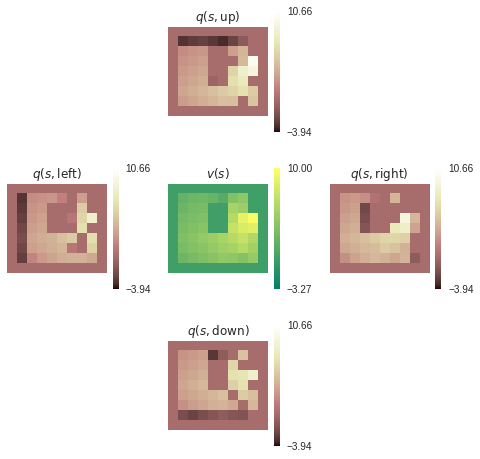

In [45]:
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)

### 2.1.2 Computational Cost

What if sampling from the environment is cheap and I don't care about data efficiency but only care about the number of updates to the model?

How do Online Q-learning, ExperienceReplay and Dyna-Q compare if I apply the same number of total updates?

**Online Q-learning**

* $\text{number_of_steps}$ = $3e4$ and $\text{num_offline_updates}$ = $0$



/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


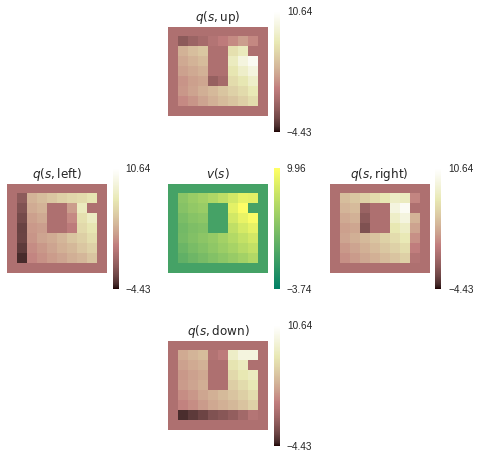

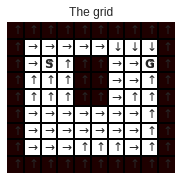

In [31]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(3e4))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

**ExperienceReplay**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


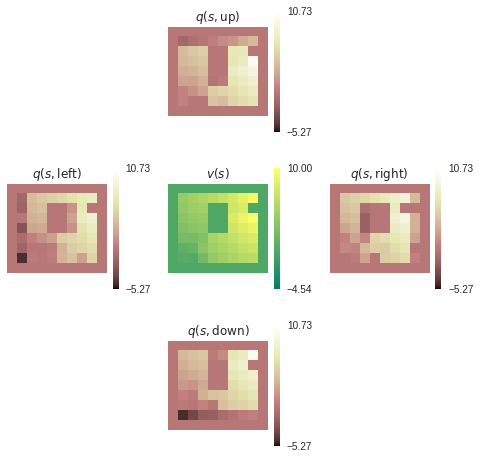

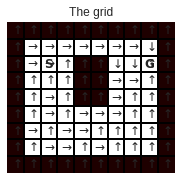

In [32]:
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

**DynaQ**

* $\text{number_of_steps}$ = $1e3$ and $\text{num_offline_updates}$ = $30$

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


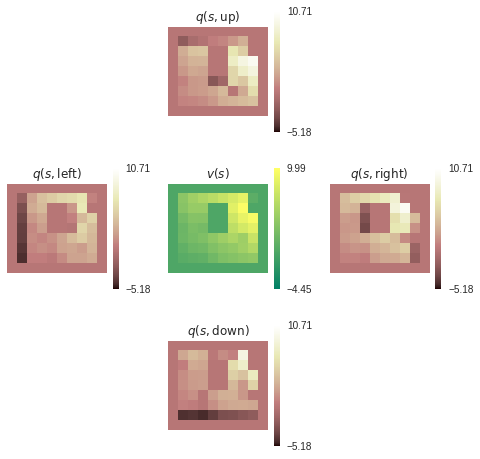

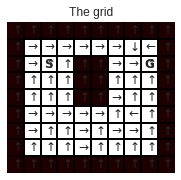

In [44]:
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(1e3))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_action_values(q)
plot_greedy_policy(grid, q)

## 2.3 Linear function approximation

We will now consider the $\text{FeatureGrid}$ domain.

And evaluate $\text{Q-learning}$, $\text{Experience Replay}$ and $\text{DynaQ}$, in the context of linear function approximation.

All experiments are run for $\text{number_of_steps}$ = $1e5$

**Online Q-learning with Linear Function Approximation**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


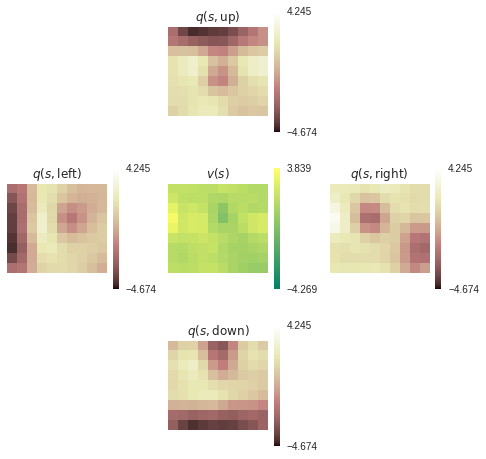

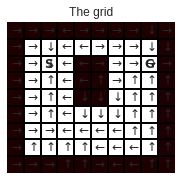

In [38]:
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=0, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in xrange(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

**Experience Replay with Linear Function Approximation**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


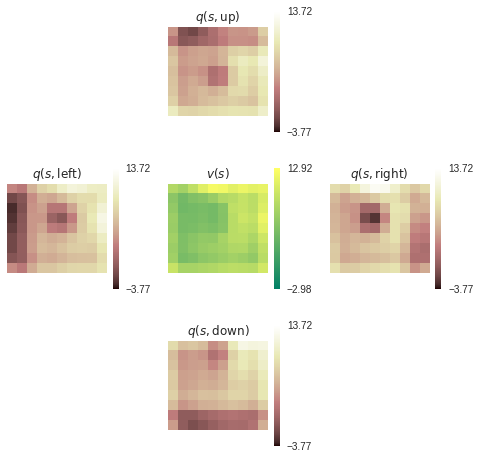

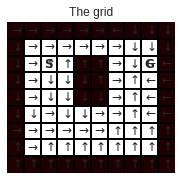

In [39]:
grid = FeatureGrid()

agent = FeatureExperienceQ(
  number_of_features=grid.number_of_features, number_of_actions=4,
  number_of_states=grid._layout.size, initial_state=grid.get_obs(),
  num_offline_updates=10, step_size=0.01, behaviour_policy=random_policy)
run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in xrange(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

![alt text](https://)**DynaQ with Linear Function Approximation**

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:58: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.


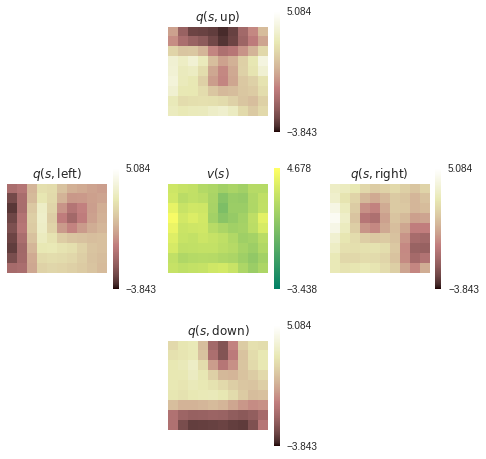

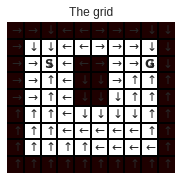

In [43]:
grid = FeatureGrid()

agent = FeatureDynaQ(
  number_of_features=grid.number_of_features, 
  number_of_actions=4,
  number_of_states=grid._layout.size, 
  initial_state=grid.get_obs(),
  num_offline_updates=10, 
  step_size=0.01,
  behaviour_policy=random_policy)

run_experiment(grid, agent, int(1e5))
q = np.reshape(
    np.array([agent.q(grid.int_to_features(i)) for i in xrange(grid.number_of_states)]),
    [grid._layout.shape[0], grid._layout.shape[1], 4])
plot_action_values(q)
plot_greedy_policy(grid, q)

## 2.4 Non stationary Environments

We now consider a non-stationary setting where after `pretrain_steps` in the environment, the goal is moved to a new location (from the top-right of the grid to the bottom-left).

The agent is allowed to continue training for a (shorter) amount of time in this new setting, and then we evaluate the value estimates.

In [0]:
pretrain_steps = 2e4
new_env_steps = pretrain_steps / 30

**Online Q-learning**

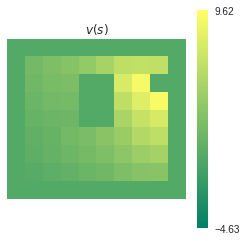

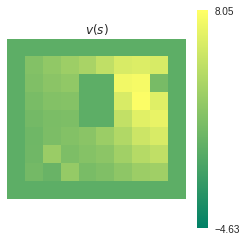

In [51]:
# Train on first environment
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=0, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

**Experience Replay**

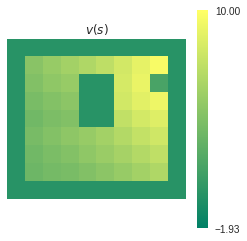

In [55]:
# Train on first environment
grid = Grid()
agent = ExperienceQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
# plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

**Dyna**

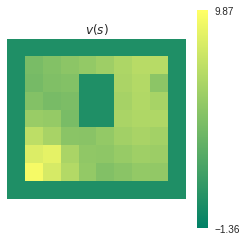

In [54]:
# Train on first environment
grid = Grid()
agent = DynaQ(
  grid._layout.size, 4, grid.get_obs(),
  random_policy, num_offline_updates=30, step_size=0.1)
run_experiment(grid, agent, int(pretrain_steps))
q = agent.q_values.reshape(grid._layout.shape + (4,))
#plot_state_value(q)

# Change goal location
alt_grid = AltGrid()
run_experiment(alt_grid, agent, int(new_env_steps))
alt_q = agent.q_values.reshape(alt_grid._layout.shape + (4,))
plot_state_value(alt_q)

## Questions

### Basic Tabular Learning

**[5 pts]** Why is the ExperienceReplay agent so much more data efficient than online Q-learning?
> ExperienceReplay has some off-line updating steps, where this method learns with the previous experience with multiple times in the simulated experience, hence we could fully learn from the experience of each step. Q-learning, however, since it's online, we have to play until it converge, while the value function may not be able to converge quickly, since for each update we have to step and get the updated value. For the same number of steps, ExperienceReply is much more data efficient than online Q-learning. 

**[5 pts]** If we run the experiments for the same number of updates, rather than the same number of steps in the environment, which among online Q-learning and Experience Replay performs better? Why?
> We could see from the section 2.1.2 computational cost that online Q-learning have the best performance. Online Q-learning update once when the agent steps onece, however, the number of updates of ExperienceReply is (1+number_of_offline_updates). For the same amount of update, Q-learning could step more so could be able to explore more and gain wider range of knowledge of the gird world, hence online Q-learning is better. 

**[5 pts]** Which among online Q-learning and Dyna-Q is more data efficient? why?
>Dyna-Q is more date efficient. The information (i.e. transition) from each step has been updated to a model of the gird, and this step is based on previous experience and update, however Q-learning just direct learn from each step. Each step provides additional information that can be used to learn a better model of the world's dynamics, and because this update on the model could control the result in a different action being best givent the model, and thus the planning precess should be repeated to use these information more effectively. So for the same amount of informative data, the model-learning step is involved in Dyna-Q learning, and we could refer to the model, as well as the direct experience for planning next policy. Hence Dyna-Q is more date efficient. 

**[5 pts]** If we run the experiments for the same number of updates, rather than the same number of steps in the environment, which among online Q-learning and Dyna-Q performs better? Why?
> Q-learning would perform better. For the same number of updates, online Q-learning will be able to step more and hence explore more around the gird world. If we don't have spare numbers of updates for model planning, Dyna-Q will waste some updates on the model planning and hence have an incomplete knowledge of the world. So if we fix the number of updates, the performance would be better if the agent goes straightly to dirct reinforcement learning, rather than share some updates on planning the model. 


### Linear function approximation

**[5 pts]** The value estimates with function approximation are considerably more blurry than in the tabular setting despite more training steps and interactions with the environment, why is this the case?
>Because they are approximated values, while in tabular setting, we store all the values from real exploring experiences. We present states in terms of feature vectors, therefore, the performance of the approximation would largly depend on the feature selection and the funtion which maps the state to a feature vector. We use a weight matrix to present which features are more informative than the others, and this will make the estimated more blurry than record the real exprience directly. 

**[5 pts]** Inspect the policies derived by training agents with linear function approximation on `FeatureGrid` (as shown by `plot_greedy_policy`). How does this compare to the optimal policy? Are there any inconsistencies you can spot? What is the reason of these?
>The policy does not converge to the optimal policy. The arrows of the policy on the path may be affected by the wall and do not point towards the goal. The accuracy is limited by the amount of information provided by the features in a linear model. Our model and feature selected is not able to fully present all the information generated from the experiences of steps. A conventional update if performed according to the linear TD(0) algorithm. Linear TP(0) is off-policy hence it may diverge if  the starting states durring training does not match the distribution creadted by the normal dynamics of the system.

### Learning in a non stationary environment

Consider now the tabular but non-stationary setting of section 2.4.

After an initial pretraining phase, the goal location is moved to a new location, where the agent is allowed to train for some (shorter) time.

**[10 pts]** Compare the value estimates of online Q-learning and Experience Replay, after training also on the new goal location, explain what you see. 
>ExperienceReply store too much previous experiences in the reply buffer, so it works perfect in the deterministic environment(Markov environment). However in the non-stationary environment, since the expreriences are not i.i.d, they are correlated, and the feedback is delayed, hence old experiences stored in the reply buffer guide the agent walking towards the previous location of the goal and we could hardly the difference of the action in the new environment compared to the old one from the plot. Q-learning is an online method, we could see that the agent move towards the new goal, but this is a bit struggling. Since the step of the new environment is just the one-thirtieth of step of the pre-training, if we increase the number of steps, with maybe larger step-sizes, the agent could be able to reach the new goal eventually. 

**[10 pts]** Compare the value estimates of online Q-learning and Dyna-Q, after training also on the new goal location, explain what you see.
>In an new environment, Dnya-Q could capture the additional inforamtion from each interaction in the simulated experience using the same updating updating equation for learning, as the new information (transition of each (state, action) pair) is gained, the model is updated for planning to better match reality. As the model is updated, the ongoing planning will gradually compute a difference way of behaving the to match the new model. However, Q-learning does not any other information to refer than the directly reinforcement learning. Therefore, the agent could accommodate itself quickly, reactive and responding instantly to the latest sensory information.

Back up your observations with visualizations of the value/policy.

